In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import os
import random
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Conv2DTranspose
from keras.layers import Dropout, Flatten, Activation, UpSampling2D, Reshape, concatenate
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

import glob
from scipy.io import loadmat
import cv2 
from cv2 import resize

import h5py

Using TensorFlow backend.


### Data preprocessing

Upload all data into images and masks.

In [2]:
brain_control_list = ['MB2b', 'MB2d', 'MB3a', 'MB5a', 'MB6d', 'MB7c']
data_path = '/Users/i_yu_b/Dropbox/Work/VUIIS/Data/GPU data/Mouse_brains/Histology/For segmentation/results'
imgs_data_path = glob.glob(data_path + '/*/*/*/*_thresh_grow_myth_equal.mat')
width = 2048
height = 2048
num_examples = len(imgs_data_path)

images = np.zeros((num_examples, width, height))
masks = np.zeros((num_examples, width, height))


for i, img_file in enumerate(imgs_data_path):
    #print('Loading {} file'.format(imgs_data_path[i]))
    mat_structure = loadmat(img_file)['axmy'][0,0]
    img = mat_structure['img']
    mask = mat_structure['BW_myelin']
    
    img = np.array(img.astype('float32'))
    mask = np.array(mask.astype('float32'))
    if img.shape != (width, height):
        img = resize(img, (width, height))
    if mask.shape != (width, height):
        mask = resize(mask, (width, height))
        
    images[i] = img
    masks[i] = mask

In [3]:
def draw_examples(images, masks):
  
    indexes = np.random.randint(images.shape[0], size=6)
    print(indexes)
    fig = plt.figure(figsize=(20, 10))
    position = 1
    for i, index in enumerate(indexes): 
        plt.subplot(3, 4, position)
        plt.title('Histology image ' + str(i))
        plt.imshow(images[index],cmap='gray')
        
        plt.subplot(3,4,position+1)
        plt.title('Manual mask ' + str(i))
        plt.imshow(masks[index],cmap='gray')
        position+=2
        
    plt.tight_layout()
    plt.show()

[  0  11 164 148  85 131]


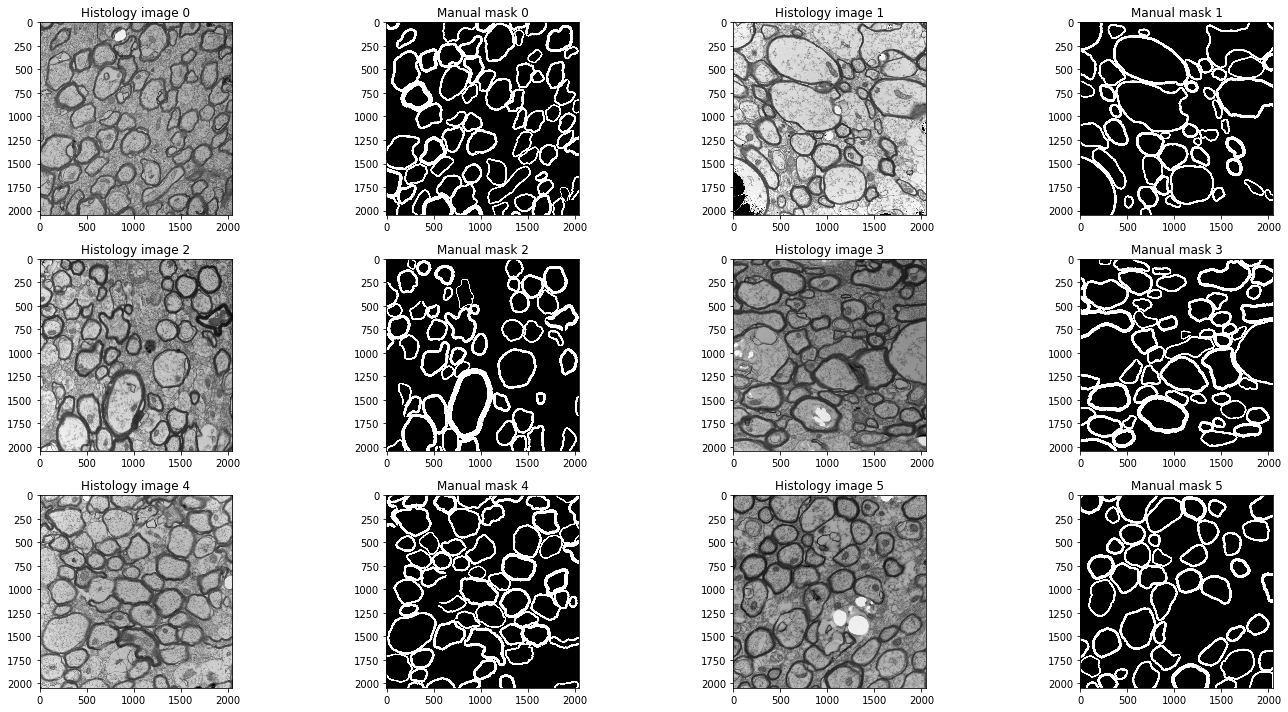

In [4]:
draw_examples(images, masks)

Save raw data

In [ ]:
from cv2 import imwrite

for i, img in enumerate(images):
    imwrite('Data/Raw/Mouse_brain/Images/control_raw_%d.png' %i,img)
for i, mask in enumerate(masks):
    imwrite('Data/Raw/Mouse_brain/Masks/control_raw_%d.png' %i,mask*255)

Crop randomly 512x512 patches, from each image we crop 50 patches

In [6]:
from cv2 import imwrite
patch_width = 512
patch_height = 512
patches_num = 50
img_patches = np.zeros((patches_num * num_examples, patch_width, patch_height))
masks_patches = np.zeros((patches_num * num_examples, patch_width, patch_height))

for example in range(num_examples):
    img = images[example]
    mask = masks[example]
    for i in range(patches_num):
        rand_x = np.random.randint(0, width - patch_width +1)
        rand_y = np.random.randint(0, height - patch_height +1)
        top = rand_y
        left = rand_x
        bottom = top + patch_height
        right = left + patch_width
        img_patch = img[top:bottom, left:right]
        mask_patch = mask[top:bottom, left:right]
        imwrite('Data/Raw/Mouse_brain/Images_patch/control_raw_%d.png' %(example*i),img_patch)
        imwrite('Data/Raw/Mouse_brain/Masks_patch/control_raw_%d.png' %(example*i), 
                mask_patch*255)
        img_patches[example*patches_num + i] = img_patch
        masks_patches[example*patches_num + i] = mask_patch


[3133 1539 5385 5929 5636 2177]


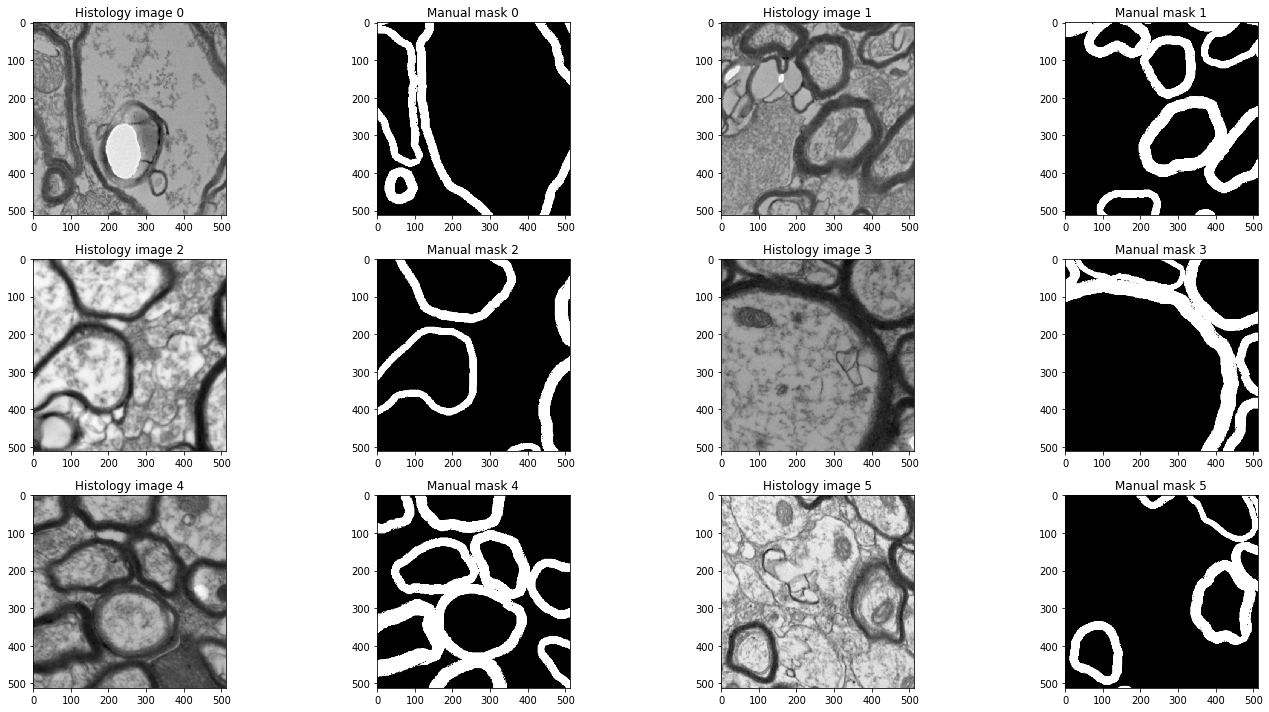

In [7]:
draw_examples(img_patches, masks_patches)

Save data into h5py format

In [11]:
hdf5_path = 'Data/Raw/Mouse_brain/control_raw_patches_hdf5'
data_shape = (len(img_patches), patch_height, patch_width)

# open a hdf5 file and create arrays
hdf5_file = h5py.File(hdf5_path, mode='w')
hdf5_file.create_dataset("data", data_shape, np.float64)
hdf5_file.create_dataset("masks", data_shape, np.float64)

# loop over images
for i in range(len(data_shape)):
    if i % 1000 == 0 and i > 1:
        print 'Train data: {}/{}'.format(i, len(data_shape))
    # save the image and calculate the mean so far
    hdf5_file["data"][i, ...] = img_patches[i]
    hdf5_file["masks"][i, ...] = masks_patches[i]
    
hdf5_file.close()

(512, 512)


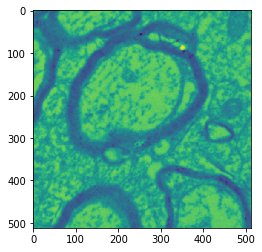

In [51]:
hdf5_path = 'Data/Raw/Mouse_brain/control_raw_patches_hdf5'
# open the hdf5 file
hdf5_file = h5py.File(hdf5_path, "r")

test = hdf5_file["data"][0, ...]
print(test.shape)
plt.imshow(test)
plt.show()

hdf5_file.close()

In [3]:
hdf5_path = 'Data/Raw/Mouse_brain/control_raw_patches_hdf5'
# open the hdf5 file
hdf5_file = h5py.File(hdf5_path, "r")

data = hdf5_file["data"][...]
masks = hdf5_file["masks"][...]

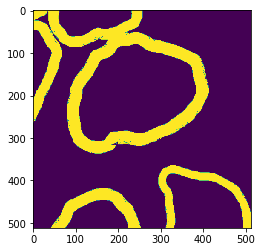

In [5]:
plt.imshow(masks[0])
plt.show()

In [53]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range = 180,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        rescale=1./255,
        shear_range=0.1,
        zoom_range = 0.1,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode='nearest')

### Building CNN

In [6]:
def dice_coef(y_true, y_pred):
    bias = 1 # to set dice coefficient = 1, when sets are empty
    # flatten masks 
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_true_flat * y_pred_flat)
    dice_coef = (2. * intersection + bias) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + bias)
    return dice_coef

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def get_unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.summary()
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model


In [7]:
img_rows = 512
img_cols = 512
model = get_unet()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 512, 512, 1)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 512, 512, 32)  320         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 512, 512, 32)  9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 256, 256, 32)  0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [ ]:
from keras.callbacks import ModelCheckpoint  

data = data.reshape(-1,512,512,1)
masks = masks.reshape(-1,512,512,1)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(data, masks, validation_split = 0.3, epochs=5, batch_size = 20)

Train on 5985 samples, validate on 2565 samples
Epoch 1/5
5985/5985 [==============================] - 47519s - loss: -4.4327e-04 - dice_coef: 4.4327e-04 - val_loss: -3.8374e-07 - val_dice_coef: 3.8374e-07
Epoch 2/5
5940/5985 [============================>.] - ETA: 368s - loss: -4.4742e-04 - dice_coef: 4.4742e-04

In [ ]:
epochs = 5
for e in range(epochs):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=32):
        model.fit(x_batch, y_batch)
        batches += 1
        if batches >= len(x_train) / 32:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break